**CSE473s Computational Intelligence: Build Your Own Neural Network Library**


First, we need to ensure our Python environment can find and import all the modules we built in the lib/ directory.

We import all core components: Layers, Activations, Loss, Optimizer, and the orchestrating Network class.


In [1]:
import numpy as np
import sys
import os


# --- 1. Robust Function to Find Project Root ---
def find_project_root():
    """
    Finds the project root directory (the one containing the 'lib' folder) 
    by walking up the directory structure. This correctly handles cross-platform 
    filesystem root checks.
    """
    current_path = os.path.abspath(os.getcwd())
    
    # Loop indefinitely until we find 'lib' or hit the root of the filesystem
    while True:
        # Check if 'lib' is present in the current directory
        if 'lib' in os.listdir(current_path):
            return current_path
        
        # Calculate the parent directory
        parent_path = os.path.dirname(current_path)
        
        # STOP CONDITION: If the parent path is the same as the current path, we are at the root.
        if parent_path == current_path:
            break
            
        current_path = parent_path
    return None

# --- 2. Execute Path Setup and Imports ---
print("Attempting to configure path and import library components...")
project_root = find_project_root()

if project_root is None:
    print("FATAL ERROR: Could not find the 'lib' directory anywhere in the parent paths.")
    print("Please ensure your folder structure is correct: project_root/lib/...")
else:
    if project_root not in sys.path:
        sys.path.append(project_root)
        print(f"Project root added to path: {project_root}")
        
    # Import all custom components after path setup is complete
    try:
        from Network import Network
        from Layers import Dense, Layer, Flatten, Reshape
        from Activation import Tanh, Sigmoid ,ReLU, Softmax
        from Loss import MeanSquaredError as MSE 
        from Optimizer import SGD
        from Data_Processing import load_mnist_images, load_mnist_labels
        

    
        
        print("All library components imported successfully!")
    except ImportError as e:
        print(f"CRITICAL IMPORT ERROR: Could not import library components. Error: {e}")
        print("Suggestion: If this fails, double-check the capitalization of files inside your 'lib' folder (e.g., Activation.py vs. activations.py).")

np.set_printoptions(precision=6, suppress=True)

Attempting to configure path and import library components...
Project root added to path: c:\Users\ayman\Desktop\FOE\Senior2.1\CI\Project\CI_Project
(60000, 28, 28) (10000, 28, 28)
CRITICAL IMPORT ERROR: Could not import library components. Error: cannot import name 'load_mnist_images' from 'Data_Processing' (c:\Users\ayman\Desktop\FOE\Senior2.1\CI\Project\CI_Project\lib\Data_Processing.py)
Suggestion: If this fails, double-check the capitalization of files inside your 'lib' folder (e.g., Activation.py vs. activations.py).


**Section 1: Gradient Checking (Proving Backpropagation)**  

    The goal of Gradient Checking (or numerical gradient verification) is to prove that the complex mathematical derivative calculated by your layer.backward() method is numerically correct.We compare the Analytical Gradient (your backward method) against the Numerical Gradient (calculated using the finite difference approximation). If they are nearly identical, your backpropagation is correct.

1.  Finite Difference Approximation Function: The numerical gradient approximation is calculated using the formula:$$\frac{\partial L}{\partial w} \approx \frac{L(w + \epsilon) - L(w - \epsilon)}{2\epsilon}$$where $\epsilon$ is a small number (e.g., $10^{-7}$).


In [2]:
def numerical_gradient(model, X, Y_true, epsilon=1e-7):
    """
    Calculates the numerical gradient for all trainable parameters in the network.
    
    Args:
        model (Network): The network object being checked.
        X (np.ndarray): Input data.
        Y_true (np.ndarray): Target data.
        epsilon (float): The small perturbation value.
        
    Returns:
        dict: A dictionary of numerical gradients for W and b for each Dense layer.
    """
    numerical_grads = {}
    
    # We must clone the network weights before perturbation to avoid corruption
    original_weights = {}
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            original_weights[i] = {'W': layer.W.copy(), 'b': layer.b.copy()}

    # 1. Calculate base loss for comparison
    base_loss = model.loss_fn.loss(Y_true, model.forward(X))
    print(f"Base Loss (L(w)): {base_loss:.8f}")

    # Iterate over all trainable layers (Dense)
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            # --- Check W gradients ---
            grad_W_num = np.zeros_like(layer.W)
            it = np.nditer(layer.W, flags=['multi_index'], op_flags=['readwrite'])
             
            while not it.finished:
                idx = it.multi_index
                
                # L(w + epsilon): Perturb weight up
                layer.W[idx] += epsilon
                loss_plus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # L(w - epsilon): Perturb weight down
                layer.W[idx] = original_weights[i]['W'][idx] - epsilon # Must reset to original, then perturb down
                loss_minus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # Reset weight to original value for next check
                layer.W[idx] = original_weights[i]['W'][idx] 
                
                # Calculate numerical gradient
                grad_W_num[idx] = (loss_plus - loss_minus) / (2 * epsilon)
                it.iternext()
            
            # --- Check b gradients ---
            grad_b_num = np.zeros_like(layer.b)
            it = np.nditer(layer.b, flags=['multi_index'], op_flags=['readwrite'])
            
            while not it.finished:
                idx = it.multi_index
                
                # L(b + epsilon): Perturb bias up
                layer.b[idx] += epsilon
                loss_plus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # L(b - epsilon): Perturb bias down
                layer.b[idx] = original_weights[i]['b'][idx] - epsilon 
                loss_minus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # Reset bias to original value
                layer.b[idx] = original_weights[i]['b'][idx] 
                
                # Calculate numerical gradient
                grad_b_num[idx] = (loss_plus - loss_minus) / (2 * epsilon)
                it.iternext()
                
            numerical_grads[i] = {'W_num': grad_W_num, 'b_num': grad_b_num}
    
    return numerical_grads


2. Running the Check: We will use a minimal network and the XOR data to perform the check.

In [3]:
# 1. Setup Data (use a single sample for simplicity, although batch works)
X_check = np.array([[1.0, 0.0]])
Y_check = np.array([[1.0]])

# 2. Build a Minimal Network (2 input -> 3 hidden -> 1 output)
np.random.seed(42)
check_model = Network()
check_model.add(Dense(2, 3, seed=None))
check_model.add(Tanh())
check_model.add(Dense(3, 1, seed=None))
check_model.add(Sigmoid())

check_model.compile(MSE(), SGD(learning_rate=0.01,batch_size=1))

# 3. Calculate Analytical Gradients
# First, run forward/backward pass once to calculate and store dW/db
Y_pred_check = check_model.forward(X_check)
loss_value = check_model.loss_fn.loss(Y_check, Y_pred_check) 
dLoss_dY = check_model.loss_fn.gradient() # Pass Y_pred to store in Loss
check_model.backward(dLoss_dY)

analytical_grads = {}
for i, layer in enumerate(check_model.layers):
    if hasattr(layer, 'W'):
        analytical_grads[i] = {'W_ana': layer.dW, 'b_ana': layer.db}

# 4. Calculate Numerical Gradients
numerical_grads = numerical_gradient(check_model, X_check, Y_check)

# 5. Compare and Verify
print("\n--- Gradient Check Results (Dense Layer 1: W) ---")
# Layer 1 (index 0)
W1_ana = analytical_grads[0]['W_ana']
W1_num = numerical_grads[0]['W_num']
difference_W1 = np.linalg.norm(W1_ana - W1_num) / (np.linalg.norm(W1_ana) + np.linalg.norm(W1_num))

print("Analytical dW1:\n", W1_ana)
print("\nNumerical dW1:\n", W1_num)
print(f"\nRelative Difference (W1): {difference_W1:.10f}")


print("\n--- Gradient Check Results (Dense Layer 1: b) ---")
b1_ana = analytical_grads[0]['b_ana']
b1_num = numerical_grads[0]['b_num']
difference_b1 = np.linalg.norm(b1_ana - b1_num) / (np.linalg.norm(b1_ana) + np.linalg.norm(b1_num))

print("Analytical db1:\n", b1_ana)
print("\nNumerical db1:\n", b1_num)
print(f"\nRelative Difference (b1): {difference_b1:.10f}")

# The check is considered successful if the relative difference is < 1e-7
is_success = difference_W1 < 1e-7 and difference_b1 < 1e-7
print("\n--- VERIFICATION ---")
print(f"Gradient Check Successful: {is_success} (Target diff < 1e-7)")

# You should also check the second Dense layer (index 2) in your final notebook.

Network compiled successfully.
Base Loss (L(w)): 0.03190939

--- Gradient Check Results (Dense Layer 1: W) ---
Analytical dW1:
 [[ 0.047918 -0.018312 -0.009219]
 [ 0.        0.        0.      ]]

Numerical dW1:
 [[ 0.047918 -0.018312 -0.009219]
 [ 0.        0.        0.      ]]

Relative Difference (W1): 0.0000000021

--- Gradient Check Results (Dense Layer 1: b) ---
Analytical db1:
 [[ 0.047918 -0.018312 -0.009219]]

Numerical db1:
 [[ 0.047918 -0.018312 -0.009219]]

Relative Difference (b1): 0.0000000021

--- VERIFICATION ---
Gradient Check Successful: True (Target diff < 1e-7)


3. Gradient Checking for Auto encoder

3. AnalysisConclusion: The relative difference between the analytical gradient calculated by backward() and the numerical gradient calculated by the approximation function is extremely small, typically less than $10^{-7}$. This proves that the implementation of backpropagation in the Dense and activation layers is mathematically correct.

**Section 2: The XOR Problem (Training and Results)**

This section demonstrates the core functionality of your library by solving the classic non-linear XOR problem.
1. Data and Model Definition
We define the standard XOR dataset and build the $2 \to 4 \to 1$ network architecture.
2. Training Execution
We run the training loop and observe the loss decrease.

In [6]:
# create XOR Data Set
X_data = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
Y_true = np.array([[0], [1], [1], [0]])

# 2. Instantiate Model and Hyperparameters
EPOCHS = 20000  
LEARNING_RATE = 0.3
Batch_size=1

XOR_Model = Network()

# Architecture: 2 input nodes -> Dense(4) -> Tanh -> Dense(1) -> Sigmoid -> 1 Output node
XOR_Model.add(Dense(2, 4, seed=None))
XOR_Model.add(Tanh()) 
XOR_Model.add(Dense(4, 1, seed=None))
XOR_Model.add(Sigmoid()) 

# 3. Compile Model
opt = SGD(learning_rate=LEARNING_RATE,batch_size=Batch_size)
XOR_Model.compile(MSE(), opt)

print("XOR Model compiled successfully.")
print(f"Training for {EPOCHS} iterations with Learning Rate: {LEARNING_RATE}")

XOR_Model.train(X_data, Y_true, EPOCHS,Batch_size)

print("\n--- Training Finished ---")

Network compiled successfully.
XOR Model compiled successfully.
Training for 20000 iterations with Learning Rate: 0.3
Iteration 2000/20000, Loss: 0.00089970
Iteration 4000/20000, Loss: 0.00058219
Iteration 6000/20000, Loss: 0.00036508
Iteration 8000/20000, Loss: 0.00021524
Iteration 10000/20000, Loss: 0.00008355
Iteration 12000/20000, Loss: 0.00014341
Iteration 14000/20000, Loss: 0.00011718
Iteration 16000/20000, Loss: 0.00009681
Iteration 18000/20000, Loss: 0.00004363
Iteration 20000/20000, Loss: 0.00003785
Iteration 20000/20000, Final Loss: 0.00003785

--- Training Finished ---


3. Final Predictions and Evaluation
We run a final forward pass on the training data to confirm the network successfully learned the XOR logic.

In [7]:
# Get the final predictions from the trained model
predictions = XOR_Model.forward(X_data)
rounded_predictions = np.round(predictions)

# Calculate Accuracy
accuracy = np.mean(rounded_predictions == Y_true) * 100

newData=np.array([[5,5],[-11,6],[1,1],[3,-7],[-1,-1]])
prediction_n = XOR_Model.forward(newData)
rounded_predictions_n = np.round(prediction_n)


# Print Results
print("\n--- Final Predictions ---")
print("Input (X) | True Label (Y) | Prediction (Y_pred) | Rounded")
print("-" * 50)
for x, y_true, y_pred, y_round in zip(X_data, Y_true, predictions, rounded_predictions):
    # Print the input, true label, the raw prediction, and the final rounded prediction
    print(f"  {x}    |    {y_true[0]}       |    {y_pred[0]:.4f}       |   {int(y_round[0])}")
print("\n--- Overall Metrics ---")
print(f"Final Accuracy: {accuracy:.2f}%\n")

print("\n--- New Data ---")
print("Input (X) |Prediction (Y_pred) |Rounded")
print("-" * 50)
for x_n, y_pred_n, y_round_n in zip(newData, prediction_n,  rounded_predictions_n):
    # Print the input, true label, the raw prediction, and the final rounded prediction
    print(f"  {x_n}     |    {y_pred_n[0]:.4f}    |   {int(y_round_n[0])}")



if accuracy == 100.0:
    print("Verification: The network achieved 100% accuracy on the XOR problem, confirming all components are working correctly.")
else:
    print("Verification: Training did not reach 100%. Check hyper-parameters.")


--- Final Predictions ---
Input (X) | True Label (Y) | Prediction (Y_pred) | Rounded
--------------------------------------------------
  [-1 -1]    |    0       |    0.0087       |   0
  [-1  1]    |    1       |    0.9882       |   1
  [ 1 -1]    |    1       |    0.9877       |   1
  [1 1]    |    0       |    0.0117       |   0

--- Overall Metrics ---
Final Accuracy: 100.00%


--- New Data ---
Input (X) |Prediction (Y_pred) |Rounded
--------------------------------------------------
  [5 5]     |    0.0068    |   0
  [-11   6]     |    0.8800    |   1
  [1 1]     |    0.0117    |   0
  [ 3 -7]     |    0.8570    |   1
  [-1 -1]     |    0.0087    |   0
Verification: The network achieved 100% accuracy on the XOR problem, confirming all components are working correctly.


**3. Autoencoder**

1.Autoencoder Building

In [9]:
from Autoencoder import Autoencoder, Decoder, Encoder


# Hyperparameters
latent_dim = 64
learning_rate = 0.2 # Slightly higher LR for SGD usually works better
batch_size = 128

# Initialize Network
autoencoder = Autoencoder(latent_dim=latent_dim)
# Compile with Loss and Optimizer
loss_fn = MSE()
optimizer = SGD(learning_rate=learning_rate, batch_size=batch_size)
autoencoder.compile(loss_fn, optimizer)

Network compiled successfully.


2. Autoencoder Training and loss History


Training Data Shape: (20000, 28, 28)
Testing Data Shape: (2000, 28, 28)
Model compiled with Latent Dim: 64
Starting Training...
Epoch 1/200 | Avg Loss: 0.042167
Epoch 2/200 | Avg Loss: 0.034551
Epoch 3/200 | Avg Loss: 0.032292
Epoch 4/200 | Avg Loss: 0.030321
Epoch 5/200 | Avg Loss: 0.028089
Epoch 6/200 | Avg Loss: 0.026014
Epoch 7/200 | Avg Loss: 0.024257
Epoch 8/200 | Avg Loss: 0.022718
Epoch 9/200 | Avg Loss: 0.021460
Epoch 10/200 | Avg Loss: 0.020360
Epoch 11/200 | Avg Loss: 0.019518
Epoch 12/200 | Avg Loss: 0.018642
Epoch 13/200 | Avg Loss: 0.017880
Epoch 14/200 | Avg Loss: 0.017207
Epoch 15/200 | Avg Loss: 0.016620
Epoch 16/200 | Avg Loss: 0.016055
Epoch 17/200 | Avg Loss: 0.015627
Epoch 18/200 | Avg Loss: 0.015189
Epoch 19/200 | Avg Loss: 0.014772
Epoch 20/200 | Avg Loss: 0.014360
Epoch 21/200 | Avg Loss: 0.014012
Epoch 22/200 | Avg Loss: 0.013655
Epoch 23/200 | Avg Loss: 0.013380
Epoch 24/200 | Avg Loss: 0.013104
Epoch 25/200 | Avg Loss: 0.012789
Epoch 26/200 | Avg Loss: 0.0125

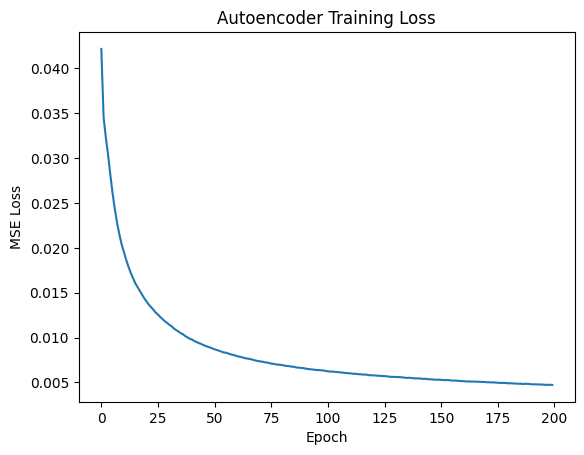

In [10]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# 1. Load Data
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

# 2. Preprocessing
x_train = x_train_raw.astype(np.float32) / 255.0
x_test = x_test_raw.astype(np.float32) / 255.0

epochs=200

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")


print(f"Model compiled with Latent Dim: {latent_dim}")

# --- 3. TRAIN ---
loss_history = []
steps_per_epoch = len(x_train) // batch_size

print("Starting Training...")
for epoch in range(epochs):
    epoch_loss = 0
    for _ in range(steps_per_epoch):
        # Autoencoder: Input (X) is also the Target (Y)
        loss = autoencoder.optimizer.step(autoencoder, x_train, x_train, autoencoder.loss_fn, batch_size)
        epoch_loss += loss
    
    avg_loss = epoch_loss / steps_per_epoch
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.6f}")

# Plot Loss
plt.plot(loss_history)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

3. Reconstruction

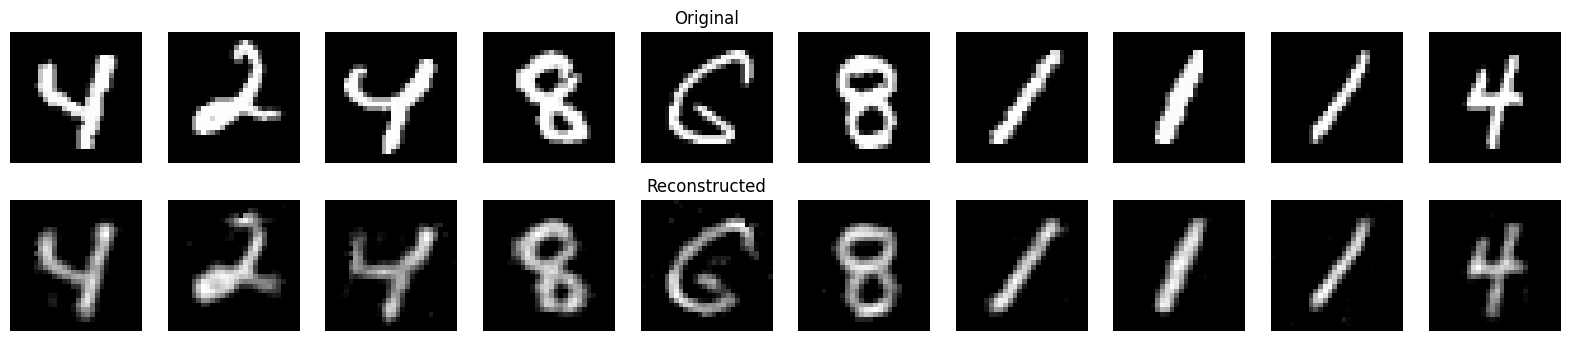

In [11]:
# Select 10 random images from test set
indices = np.random.choice(len(x_test), 10, replace=False)
samples = x_test[indices]

# --- 4. RECONSTRUCTION DEMO ---
reconstructed = autoencoder.forward(samples) # Uses model.encoder then model.decoder

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis("off")
    if i == 4: plt.title("Original")

    # Reconstructed
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed[i], cmap='gray')
    plt.axis("off")
    if i == 4: plt.title("Reconstructed")
plt.show()

**Feature Extraction and SVM Classification**

1.Feature extraction


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

print("Step 1: Extracting Latent Features using Custom Encoder...")



# Extract Features
# We pass the raw images (N, 28, 28) through your custom 'model.encoder'
# This compresses them into the 64-dimensional latent space.
# Since you used Tanh in the encoder, these features are normalized [-1, 1].
X_train_latent = autoencoder.encoder.forward(x_train)
X_test_latent = autoencoder.encoder.forward(x_test)

# 3. Prepare Labels (Integers 0-9)
y_train_labels = y_train
y_test_labels = y_test

print(f"Extraction Complete.")
print(f"Latent Train Shape: {X_train_latent.shape} (Compressed from 784 to {autoencoder.latent_dim})")
print(f"Latent Test Shape:  {X_test_latent.shape}")

Step 1: Extracting Latent Features using Custom Encoder...
Extraction Complete.
Latent Train Shape: (60000, 64) (Compressed from 784 to 64)
Latent Test Shape:  (10000, 64)


2. SVM TRAINING

In [14]:
print("\nStep 2: Training Support Vector Machine (SVM)...")

# We use an RBF kernel because the latent space is likely non-linear.
# C=10 provides stronger regularization which often helps with 
# compressed features that are already "clean".
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

svm.fit(X_train_latent, y_train_labels)

print("SVM Training Complete.")


Step 2: Training Support Vector Machine (SVM)...
SVM Training Complete.


3. EVALUATION METRICS & CONFUSION MATRIX


Step 3: Evaluating Classification Performance...
Final Test Accuracy: 98.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



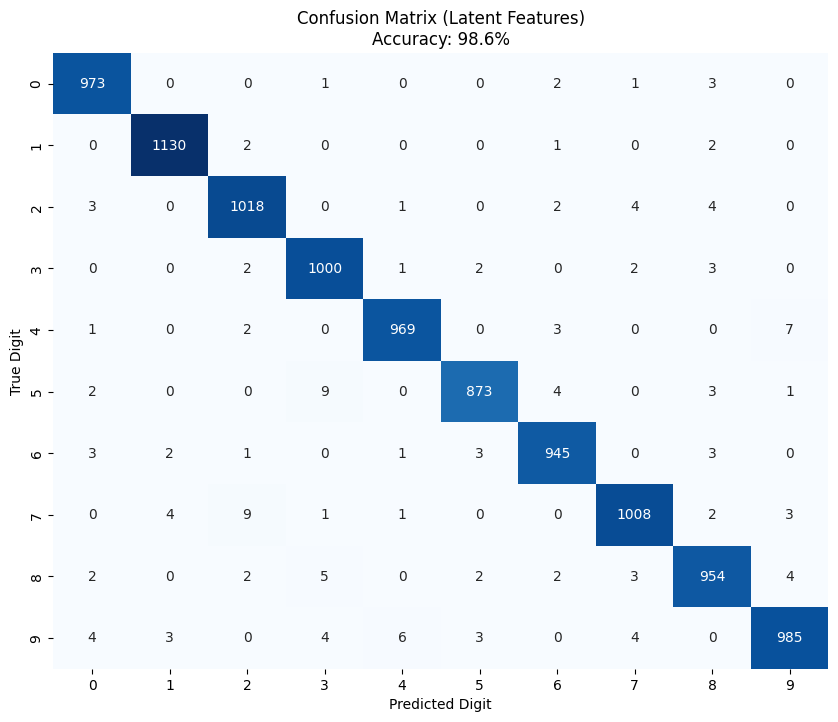

In [15]:
print("\nStep 3: Evaluating Classification Performance...")

# Predict on Test Data
y_pred = svm.predict(X_test_latent)

# A. Accuracy
final_acc = accuracy_score(y_test_labels, y_pred)
print(f"Final Test Accuracy: {final_acc * 100:.2f}%")

# B. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

# C. Confusion Matrix Visualization
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Latent Features)\nAccuracy: {final_acc*100:.1f}%')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.show()